In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


def irRemoval(xf):
    xf['IR'] = 0.41*(xf['R']*0.61 + xf['G'] + xf['B']*1.6 - 0.98 * xf['C'])/2
    #replace negative values in IR with 0
    num = xf['IR']._get_numeric_data()
    num[num < 0] = 0
    xf['RC'] = xf['R']*0.61 - xf['IR']
    xf['GC'] = xf['G'] - xf['IR']
    xf['BC'] = xf['B']*1.6 - xf['IR']
    xf['CC'] = xf['C']*0.98 - xf['IR']
    xf = removeNegative(xf)
    xf.loc[xf.RC == 0, 'BC'] = 0
  
    
    return xf


def removeNegative(xn):
    xn = pd.DataFrame(xn)
    num = xn._get_numeric_data()
    num[num < 0] = 0
    return xn


def fit(xfit, meter):    
    reg = LinearRegression().fit(xfit[['RC', 'GC', 'BC','CC']], xfit[meter] )
    score= reg.score(xfit[['RC','GC','BC','CC']], xfit[meter])
    coeff = reg.coef_
    off = reg.intercept_
    return reg,score,coeff,off


def predict(reg, xpre, meter):
    y = reg.predict(xpre[['RC', 'GC', 'BC','CC']])
    MSE = mean_squared_error(xpre[meter], y)
    Var = r2_score(xpre[meter], y)
    y = [0 if x < 2 else x for x in y]
    return y, MSE, Var


def errorfun(xe, xfitted, meter): 
    x3 =  (xe[meter] - xfitted)/xfitted
#     x3 = [0 if x != -1 else x for x in x3]
    x3[x3 == -1 ] = 0
    return x3


#here is the XYZ to Lux and CCT calculation
def CCT(xcct,offX,offY,offZ,coeffX,coeffY,coeffZ):    
    X = offX + xcct['RC'] * coeffX[0] + xcct['GC'] \
    * coeffX[1] + xcct['BC'] * coeffX[2] + xcct['CC'] * coeffX[3]
    X =[0 if x < 2 else x for x in X]
    X = np.array(X)

    Y = offY + xcct['RC'] * coeffY[0] + xcct['GC'] \
    * coeffY[1] + xcct['BC'] * coeffY[2] + xcct['CC'] * coeffY[3]
    
    Y = [0 if x < 2 else x for x in Y]
    Y =np.array(Y)

    Z = offZ + xcct['RC'] * coeffZ[0] + xcct['GC'] \
    * coeffZ[1] + xcct['BC'] * coeffZ[2] + xcct['CC'] * coeffZ[3]
    Z = [0 if x < 2 else x for x in Z]
    Z = np.array(Z)
    sum = X + Y + Z
    x = X / sum
    y = Y / sum
    n = (x - 0.3320)/(0.1858 - y)
    CCT = 449.0 * n**3 + 3525.0 * n**2 + 6823.3 * n + 5520.33
#     CCT = 437 * n**3 + 3601 * n**2 + 6861 * n + 5517
    error = (CCT - xcct['MeterCCT'])/xcct['MeterCCT']
    
    return CCT, error, X, Y, Z



def CCTPredict(xcctpre, X, Y, Z):
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    sum = X + Y + Z
    x = X/sum
    y = Y/sum
    n = (x - 0.3320)/(0.1858 - y)
    CCT = 449.0 * n**3 + 3525.0 * n**2 + 6823.3 * n + 5520.33
#     CCT = 437 * n**3 + 3601 * n**2 + 6861 * n + 5517
    error = (CCT - xcctpre['MeterCCT'])/xcctpre['MeterCCT']
    
    
    return CCT, error

    
def traintestslipt(xf):
    train, test = train_test_split(xf, test_size=0.1)
    return train, test
    


#by book method for CCT calculation
# def CCTBook(xcctbook):
#     X = xcctbook['RC'] * -0.14282 + xcctbook['GC'] *1.54924 * xcctbook['BC']*-0.95641
#     Y = xcctbook['RC'] * -0.32466 + xcctbook['GC'] *1.57837 * xcctbook['BC']*-0.73191
#     Z = xcctbook['RC'] * -0.68202 + xcctbook['GC'] *0.77073 * xcctbook['BC']*0.56332
#     x = X / (X + Y + Z)
#     y = Y / (X + Y + Z)
#     n = (x - 0.3320)/(0.1858 - y)
#     CCT = 437.0 * n**3 + 3601.0 * n**2 + 6861.0 * n + 5517.0
#     error = (CCT - xcctbook['MeterCCT'])/xcctbook['MeterCCT']
#     return CCT, error


In [51]:
############
if __name__ == "__main__":
    dataRaw = pd.read_excel('redrixEVT.xlsx')
    data, dataTest = traintestslipt(dataRaw)
    datanoIR = irRemoval(data)
    dataTestnoIR = irRemoval(dataTest)   
       
    regX,scoreX,coeffX,offX = fit(datanoIR, 'MeterX')
    regY,scoreY,coeffY,offY = fit(datanoIR, 'MeterY')
    regZ,scoreZ,coeffZ,offZ = fit(datanoIR, 'MeterZ')

    Xpredict,MSEX,VarX = predict(regX,dataTestnoIR, 'MeterX')

    Ypredict,MSEY,VarY = predict(regY,dataTestnoIR, 'MeterY')

    Zpredict,MSEZ,VarZ = predict(regZ,dataTestnoIR, 'MeterZ')    
    
    errorX = errorfun(dataTestnoIR, Xpredict, 'MeterX')
    errorY = errorfun(dataTestnoIR, Ypredict, 'MeterY')
    errorZ = errorfun(dataTestnoIR, Zpredict, 'MeterZ')      
    
#     CCTfit, errorfit = CCT(dataTestnoIR, offX, offY, offZ, coeffX, coeffY, coeffZ)
   
    CCTpredict, errorpredict = CCTPredict(dataTestnoIR, Xpredict, 
                                          Ypredict, Zpredict)
#     dataVal = pd.read_excel('C18TestDataALS95210JDBU0G02S.xlsx')
#     dataValnoIR = irRemoval(dataVal)
#     CCTfit, errorfit, Y = CCT(dataValnoIR, offX, offY, offZ, coeffX, coeffY, coeffZ)
    
   

C:\Users\afliu\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\afliu\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\afliu\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [52]:
dataTestnoIR

,Computer,Lamp,LM_Lux,ATIME Cycle,ATIME,AGAIN,CR,RR,GR,BR,...,MeterX,MeterY,MeterZ,Meterlux,MeterCCT,IR,RC,GC,BC,CC
1,TPK_#1,D40,761.9,107.805755,299.7,16,3327.836364,2004.036364,798.981818,655.000000,...,765.9,761.9,492.9,761.9,4041,0.0,2904.214459,1898.148330,2489.743076,7747.851522
3,TPK_#1,TL84,1362.0,107.805755,299.7,16,3159.914286,1664.885714,925.057143,536.171429,...,1372.0,1362.0,762.0,1362.0,3792,0.0,2412.723268,2197.666619,2038.059698,7356.896203
47,HH_#2,SP03,3464.0,107.805755,299.7,4,3022.520000,1709.740000,813.680000,522.400000,...,3456.0,3464.0,1849.0,3464.0,3789,0.0,9910.901259,7732.267734,7942.850584,28148.062131
19,HH_#1,TL84,1372.0,107.805755,299.7,4,1035.520000,545.040000,322.260000,194.000000,...,1380.0,1372.0,754.0,1372.0,3775,0.0,3159.449754,3062.383984,2949.680347,9643.569372
41,HH_#2,CWF,1176.0,107.805755,299.7,16,3933.320000,2347.220000,1032.880000,557.200000,...,1279.0,1176.0,420.0,1176.0,2912,0.0,3401.550185,2453.822356,2117.992125,9157.535413


In [53]:
Ypredict

[799.7375670523379,
 1019.6266309271426,
 3423.0528449287563,
 1326.3456303951457,
 1191.9857800495433]

In [54]:
CCTpredict

array([3917.01579235, 3635.60950233, 3687.56230221, 3594.43070821,
       3021.72238322])

In [55]:
errorpredict =pd.DataFrame(errorpredict)
errorpredict = errorpredict.replace([np.inf, -np.inf], np.nan)
errorpredict = errorpredict.fillna(0)


In [56]:
errorpredict = errorpredict.to_numpy()

(-20.0, 20.0)

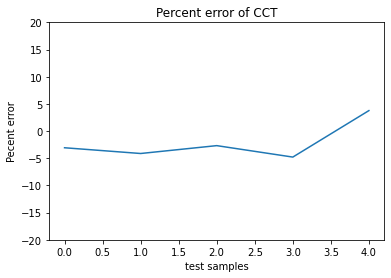

In [57]:
plt.plot(errorpredict*100)
plt.title('Percent error of CCT')
plt.xlabel("test samples")
plt.ylabel("Pecent error")
plt.ylim(-20, 20)

In [58]:
scoreX, scoreY, scoreZ

(0.9910458200828061, 0.9950548283384971, 0.9949225494306511)

In [59]:
offX, offY, offZ

(61.602194190310456, 39.373434138447124, 7.042372764329684)

In [126]:
list = [offX, offY, offZ]

In [127]:
list = np.array(list)

In [128]:
list.reshape(3,1)

array([[66.47729532],
       [40.95355984],
       [ 5.08596128]])

In [129]:
coeffX, coeffY, coeffZ

(array([ 0.00222243,  0.51877192, -0.28664117,  0.0586877 ]),
 array([-0.15384715,  0.40454969, -0.237452  ,  0.13102168]),
 array([-0.79005309, -0.35553576,  0.13997097,  0.40223911]))

In [130]:
Zpredict

[39.10165801939297,
 276.0875848668759,
 1155.5706452266984,
 897.0984228133925,
 1927.637004373839]

In [131]:
offZ

5.085961281052107

In [132]:
offX

66.47729531891889

In [134]:
offY

40.953559839080526

In [135]:
CCT, error = CCTPredict(datanoIR, datanoIR['MeterX'], datanoIR['MeterY'], datanoIR['MeterZ'])

C:\Users\afliu\anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide
C:\Users\afliu\anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide


In [136]:
error

25    0.000732
6    -0.001073
3     0.000740
19    0.001216
44   -0.001216
13   -0.012617
26    0.000812
27    0.000868
1     0.001972
24   -0.000563
16         NaN
42    0.000632
10    0.000716
11    0.000106
7    -0.001071
29   -0.013108
17    0.001914
34   -0.001512
22   -0.000236
40   -0.000668
33    0.002034
5     0.001571
43    0.000375
47    0.001205
2    -0.001855
37    0.001399
30   -0.001748
20    0.001490
45   -0.011534
21    0.001034
12   -0.001995
31    0.001216
46   -0.001829
9    -0.000404
36    0.001562
0          NaN
18   -0.001933
38   -0.000845
4     0.001894
41    0.000541
35    0.002165
39   -0.000460
8    -0.001024
Name: MeterCCT, dtype: float64

In [137]:
Ypredict

[24.47292542974922,
 846.5714148315197,
 1277.2541218888157,
 2525.666277890724,
 3348.5782429752053]

In [138]:
Zpredict

[39.10165801939297,
 276.0875848668759,
 1155.5706452266984,
 897.0984228133925,
 1927.637004373839]

In [139]:
errorX = pd.DataFrame(errorX)
errorX

,MeterX
32,0.000000
23,0.018074
14,-0.018271
28,0.018169
15,-0.006494


In [140]:
errorY = pd.DataFrame(errorY)
errorY

,MeterY
32,0.000000
23,-0.001856
14,-0.017423
28,0.005675
15,-0.005548


(-12.0, 12.0)

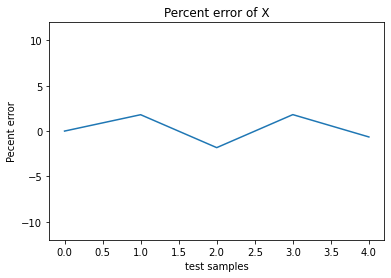

In [141]:
errorX = pd.DataFrame(errorX)
errorX = errorX.to_numpy()
plt.plot(errorX*100)
plt.title('Percent error of X')
plt.xlabel("test samples")
plt.ylabel("Pecent error")
plt.ylim(-12, 12)

(-20.0, 20.0)

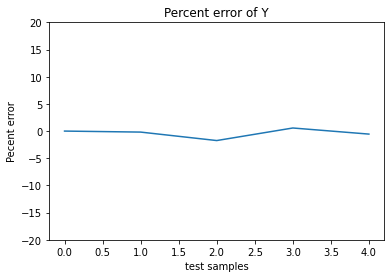

In [142]:
errorY = pd.DataFrame(errorY)
errorY = errorY.to_numpy()
plt.plot(errorY*100)
plt.title('Percent error of Y')
plt.xlabel("test samples")
plt.ylabel("Pecent error")
plt.ylim(-20, 20)

(-12.0, 12.0)

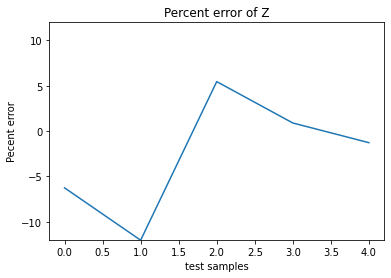

In [98]:
errorZ = pd.DataFrame(errorZ)
errorZ = errorZ.to_numpy()

plt.plot(errorZ*100)
plt.title('Percent error of Z')
plt.xlabel("test samples")
plt.ylabel("Pecent error")
plt.ylim(-12, 12)


In [99]:
dataVal = pd.read_excel('testdata_DVT_Kohaku.xlsx')
dataValnoIR = irRemoval(dataVal)
XValpredict,MSEXVal,VarXVal = predict(regX,dataValnoIR, 'MeterX')

YValpredict,MSEY,VarYVal = predict(regY,dataValnoIR, 'MeterY')

ZValpredict,MSEZ,VarZVal = predict(regZ,dataValnoIR, 'MeterZ')  
CCTValpredict, errorValpredict = CCTPredict(dataValnoIR, XValpredict, 
                                          YValpredict, ZValpredict)
    

In [101]:
dataVal

,light source,R,G,B,C,MeterX,MeterY,MeterZ,Meterlux,MeterCCT,IR,RC,GC,BC,CC
0,LIFX7000,1941,1357,1232,4139,1102,1079,1597,1079,8922,93.47795,1090.53205,1263.52205,1877.72205,3962.74205
1,LIFX6500,2128,1444,1281,4434,1180,1158,1595,1159,7836,91.50380,1206.57620,1352.49620,1958.09620,4253.81620
2,LIFX6000,2154,1412,1222,4373,1163,1143,1442,1143,6867,81.09800,1232.84200,1330.90200,1874.10200,4204.44200
3,LIFX5500,2143,1349,1133,4221,1123,1104,1252,1104,5993,68.15225,1239.07775,1280.84775,1744.64775,4068.42775
4,LIFX4500,2137,1205,942,3902,1042,1016,845,1017,4476,39.32105,1264.24895,1165.67895,1467.87895,3784.63895
5,LIFX3500,2085,1008,716,3465,944,892,420,892,3261,6.09875,1265.75125,1001.90125,1139.50125,3389.60125
6,LIFX8000,1664,1221,1150,3692,1066,1040,1692,1040,11010,93.86540,921.17460,1127.13460,1746.13460,3524.29460


In [55]:
CCTValpredict

array([ 9167.37125486,  7769.68954376,  6683.90745517,  5761.58285646,
        4386.53215214,  3437.2390767 , 13004.90637317])

In [45]:
YValpredict

[814.0027257328575,
 905.4478648949089,
 924.9888212853549,
 927.9616168498602,
 916.2427931613881,
 854.0093259283244]

In [46]:
dataVal['LuxError']=(YValpredict - dataVal['Meterlux'])/dataVal['Meterlux']*100
dataVal['CCTError']=(CCTValpredict - dataVal['MeterCCT'])/dataVal['MeterCCT']*100

<function matplotlib.pyplot.show(*args, **kw)>

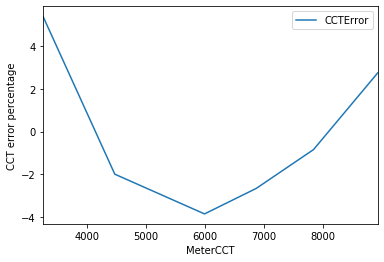

In [52]:
dataVal.plot(y = 'CCTError',x = 'MeterCCT')
plt.ylabel('CCT error percentage')
plt.show

ValueError: Unrecognized character L in format string

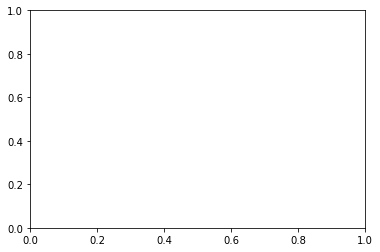

In [102]:
plt.plot( 'percentage', 'LuxError', data=dataVal, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'percentage', 'CCTError', data=dataVal, marker='', color='olive', linewidth=2)
plt.xlabel('Ink transmittance variation in percentage')
plt.ylabel('Lux and CCT error percentage')
plt.legend()
plt.show()